In [1]:
import matplotlib.pyplot as plt 
from scipy import stats
import itertools
import pandas as pd
import seaborn as sns
import pickle
import numpy as np

In [2]:
# List of all model names and their correponding directories
root='/gpfs/bbp.cscs.ch/data/scratch/proj9/bisimplices/simulations/'
# Names
models_base=["Baseline"]
models_remove=["RC - 4", #"RC - all",
               "RC - 3", #"RC - 456",
               "RC - 2", # "RC - 56 & 456",
               "RC - 1", #"RC - 56",
               #"RC - 2 (ctr)", #"RC - 456 (ctr)",
               #"RC - 3 (ctr)", #"RC - 56 & 456 (ctr)",
               #"RC - 4 (ctr)", #"RC - 56 (ctr)",
              ] 
models_distance=["Order 1",
                 "Order 2",
                 "Order 3",
                 "Order 4",
                 "Order 5"]
models_add=['RC + 2', #'RC + 4',
            'RC + 1',
            #'RC + 1 (ctr)', #'RC + 4 (ctr)',
            #'RC + 2 (ctr)'
           ]
models_enhanced=[f'670k']+[f'{n}00k' for n in (np.arange(5)+1)[::-1]]
# Paths to simulations and other data
sims_base=["BlobStimReliability_O1v5-SONATA_Baseline"]
sims_remove=["BlobStimReliability_O1v5-SONATA_RecipRemoval_Unstruct-3",
             "BlobStimReliability_O1v5-SONATA_RecipRemoval_StructDim456",
             "BlobStimReliability_O1v5-SONATA_RecipRemoval_StructDim56_456",
             "BlobStimReliability_O1v5-SONATA_RecipRemoval_StructDim56",
             #"BlobStimReliability_O1v5-SONATA_RecipRemoval_Unstruct-2",
             #"BlobStimReliability_O1v5-SONATA_RecipRemoval_Unstruct-1",
             #"BlobStimReliability_O1v5-SONATA_RecipRemoval_Unstruct-0"
            ]
sims_distance=["BlobStimReliability_O1v5-SONATA_ConnRewired_mc2EE_Order1",
               "BlobStimReliability_O1v5-SONATA_ConnRewired_mc2EE_Order2",
               "BlobStimReliability_O1v5-SONATA_ConnRewired_mc2EE_Order3",
               "BlobStimReliability_O1v5-SONATA_ConnRewired_mc2EE_Order4",
               "BlobStimReliability_O1v5-SONATA_ConnRewired_mc2EE_Order5"]
sims_add=['BlobStimReliability_O1v5-SONATA_ConnAdd_RecipStruct0x4',
          'BlobStimReliability_O1v5-SONATA_ConnAdd_RecipStruct0x2',
          #'BlobStimReliability_O1v5-SONATA_ConnAdd_Control0x4',
          #'BlobStimReliability_O1v5-SONATA_ConnAdd_Control0x2'
         ]
sims_enhanced=[f'BlobStimReliability_O1v5-SONATA_ConnRewireEnhanced{n}K' for n in 
               [670, 500, 400, 300, 200, 100]] 

models= models_base + models_distance +  models_remove + models_add + models_enhanced
sims = sims_base + sims_distance +  sims_remove +sims_add + sims_enhanced

In [3]:
# Load data 
# Reliability 
rels={}
for i, sim_name in enumerate(sims):
    rel_path=f'{root}{sim_name}/working_dir/reliability_basic.npz'
    rels[models[i]]=np.load(rel_path)['reliability']
rels=pd.DataFrame.from_dict(rels)
# Simplex counts 
sc={}
for i, sim_name in enumerate(sims):
    if sim_name in sims_enhanced: # For enhanced connectomes only EE simplex counts where computed, because full was too expensive
        sc[models[i]]=pd.read_pickle(f'{root}{sim_name}/working_dir/simplex_counts_EE.pkl')
    else:
        sc[models[i]]=pd.read_pickle(f'{root}{sim_name}/working_dir/simplex_counts.pkl')['simplex_counts_EXC']

sc=pd.DataFrame.from_dict(sc)

# Average firing rates
fr={}
for i, sim_name in enumerate(sims):
    fr[models[i]]=pd.read_hdf(f'{root}{sim_name}/working_dir/df_rates.h5').query("synapse_class=='EXC'")['avg_rate']
fr=pd.DataFrame.from_dict(fr)
fr.iloc[np.where(fr>10)]=np.nan # Removing extreme outlier

#### Statistical tests

In [4]:
# Checking globally if means are different
print(" Global Kruskal-Wallis H-test", stats.kruskal(*list(rels.values.T),nan_policy='omit'))
# Post-hoc pairwise comparison
models=rels.columns
pvals=pd.DataFrame(index=pd.MultiIndex.from_tuples(list(itertools.combinations(models,r=2))),
                  columns=['pvalue']).astype(float)
for model_1,model_2 in pvals.index:
    pvals.loc[(model_1,model_2)]=stats.kruskal(*[rels[model_1], rels[model_2]], 
                                                       nan_policy= 'omit').pvalue.astype(float)


 Global Kruskal-Wallis H-test KruskalResult(statistic=11790.277795569156, pvalue=0.0)


#### Percentage of edges changed and change in mean and skew

In [5]:
means=rels.mean(axis=0)
skew=rels.apply(lambda x: stats.skew(x, nan_policy='omit'), axis=0)
edge_count=pd.DataFrame(sc.loc[1]).rename(columns={1:"edges"})
edge_count["change"]=np.nan
edge_count.loc[[f"Order {i}" for i in np.arange(5)+1], "change"]=100
edge_count.loc[:, "change"].iloc[6:-6]=np.abs(edge_count.loc["Baseline", "edges"]-edge_count.loc[:, "edges"].iloc[6:-6])*100/edge_count.loc["Baseline", "edges"]
edge_count.loc[:, "change"].iloc[-6:]=np.append(670000, (np.arange(5)+1)[::-1]*100000)*100/edge_count.loc["Baseline", "edges"]
edge_count["Mean_change"]=np.abs(means-means.Baseline)
edge_count["Skewness_change"]=np.abs(skew-skew.Baseline)

# Plotting

In [6]:
# Plotting functions 
def plot_kde(ax, models, plot_baseline=True,
             linewidth=3, linewidth_base=2, linestyle_base="dotted", alpha_base=0.75,
             labelsize=14, ticksize=12):
    sns.kdeplot(rels[models],ax=ax, palette=colors_dict,linewidth=linewidth, clip=[0,1], common_norm=False)
    if plot_baseline:
        sns.kdeplot(rels[['Baseline']],ax=ax, palette=colors_dict,linewidth=linewidth_base, clip=[0,1], 
                 linestyle=linestyle_base, alpha=alpha_base)
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.spines[["top","right"]].set_visible(False)
    ax.get_legend().remove()
    return ax
def plot_sc(ax, models, plot_baseline=True,
             linewidth=3, labelsize=14, ticksize=12,
           linewidth_base=2,linestyle_base="dotted", alpha_base=0.75):
    for i, model in enumerate(models):
        ax.plot(sc[model], label=model,c=colors_dict[model],linewidth=linewidth)
    if plot_baseline: 
        ax.plot(sc['Baseline'], label='baseline',c=colors_dict['Baseline'], 
                alpha=alpha_base, linewidth=linewidth_base,linestyle=linestyle_base)
    ax.set_xlabel("Dimension",fontsize=labelsize)
    ax.spines[["top","right"]].set_visible(False)
    ax.tick_params(labelsize=ticksize)
    return ax

def plot_mean_median(ax, x, y, models, cmap, labelsize=14, s=20, vmin=0.2, vmax=0.9):
    n=len(models)
    colors = cmap(np.linspace(vmin, vmax,len(models)))
    ax.scatter(x.loc[models],y.loc[models],c=colors,s=20)
    min_v=min(x.min(), y.min())-0.01
    max_v=max(x.max(), y.max())+0.01
    ax.set_xlim(min_v, max_v)
    ax.set_ylim(min_v, max_v)
    return ax

def plot_bar(ax, height, labelsize,normalized=True, ):
    if normalized: height=height-height.Baseline
    ax.axline((0,height.Baseline), slope=0, color="black", 
              linestyle="dotted", linewidth=linewidth_base)
    height=height.drop("Baseline")
    colors=[colors_dict[key] for key in height.index]
    ax.bar(x=range(len(height)), height=height.values, color=colors)
    ax.set_xticks(range(len(height)), height.index, rotation=90, fontsize=labelsize)
    ax.spines[:].set_visible(False)

def plot_fr(ax, log=True, plottype="counts"):
    bins=np.linspace(0,4,40)
    if plottype=="counts":
        centers=(bins[:-1]+bins[1:])/2
        for model in fr.columns:
            counts, _ = np.histogram(fr[model], bins=bins)
            if model!="Baseline":
                ax.plot(centers, counts, color=colors_dict[model],linewidth=linewidth)
            else:
                ax.plot(centers, counts, color=colors_dict[model],linestyle=linestyle_base, linewidth=linewidth_base)
    elif plottype=="hist":
        for model in fr.columns: 
            if model!="Baseline":
                ax.hist(fr[model], histtype="step", color=colors_dict[model],linewidth=linewidth, bins=bins)
        ax.hist(fr["Baseline"], histtype="step", color=colors_dict["Baseline"],linestyle=linestyle_base, linewidth=linewidth_base, 
                bins=bins)
    if log==True: ax.set_yscale("log")
    ax.spines[["right", "top"]].set_visible(False)

def plot_mean_v_median(ax, center_to_baseline=True):
    x=rels.mean(); y=rels.median()
    if center_to_baseline: x=x-x.Baseline; y=y-y.Baseline
    ax.axline((np.min([x.min(), y.min()]), np.min([x.min(), y.min()])), slope=1, 
              color="black", linestyle="dotted", linewidth=linewidth_base)
    ax.set_aspect('equal')
    for model in x.index:
        marker ="*" if model =="Baseline" else "o"
        ax.scatter(x[model], y[model],color=colors_dict[model], marker=marker, s=2)
    ax.set_xlabel("Mean", fontsize=ticksize)
    ax.set_ylabel("Median", fontsize=ticksize)
    ax.spines[:].set_visible(False)

def plot_change_single(ax, metric, models, marker, plot_line=True):
    df=edge_count.loc[models]
    c=[colors_dict[key] for key in models]
    ax.plot(df.change, df[metric], color=c[(len(c)//2)-1], linestyle="dotted", linewidth=1)
    ax.scatter(df.change, df[metric], marker=marker, color=c, s=1)
    ax.set_xlabel("% Edges", fontsize=labelsize) 
    ax.set_ylabel(f"{metric[:-7]}", fontsize=labelsize)
    ax.spines[:].set_visible(False)

def plot_change(ax_mean, ax_skew):
    for models in [models_add, models_remove, models_enhanced]:
        marker = "*" if models == models_add or models == models_remove else  "o"
        plot_change_single(ax_mean,"Mean_change",  models, marker)
        plot_change_single(ax_skew,"Skewness_change",  models, marker)

In [7]:
# Figure settings and color schemes 
titlesize=8
labelsize=6
ticksize=4
marker_size=2
conversion=2.54
#conversion=1.5
linewidth=2; linewidth_base=1; linestyle_base="dotted"; alpha_base=0.75

# Setting up colors 
vmin=0.2; vmax=0.9
cmaps_dict={
    'remove':{
        'cmap':plt.colormaps['summer_r'],
        'models': models_remove},
    'distance':{
        'cmap':plt.cm.Blues, 
        'models':models_distance},
    'add':{
        'cmap':plt.cm.RdPu,
        'models': models_add
    },
    'enhanced':{
        'cmap':plt.cm.Reds,
        'models': models_enhanced
    }
}
colors_dict={"Baseline": "black"}
for key in cmaps_dict:
    tmp=cmaps_dict[key]['cmap'](np.linspace(vmin, vmax,len(cmaps_dict[key]['models'])))
    colors_dict.update({cmaps_dict[key]['models'][i]:tmp[i] for i in range(len(tmp))})


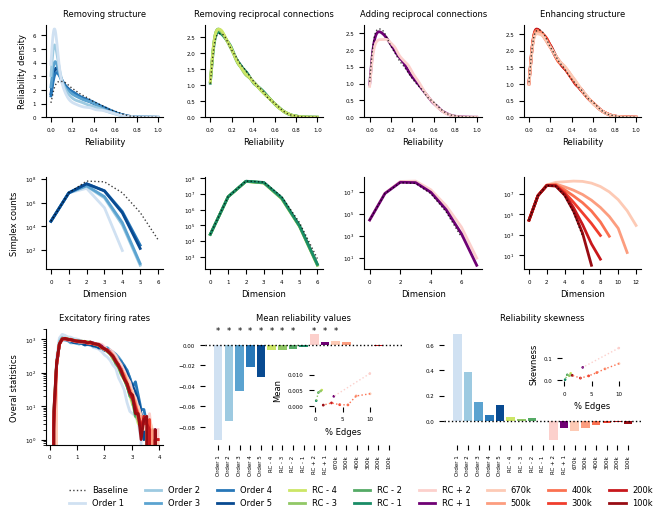

In [8]:
width=21*0.8/conversion
mosaic = [['rel_a', 'rel_a', 'rel_b', 'rel_b', 'rel_c', 'rel_c', 'rel_d', 'rel_d'],
          ['sc_a', 'sc_a', 'sc_b', 'sc_b', 'sc_c', 'sc_c', 'sc_d', 'sc_d'],
          ['fr', 'fr', 'mean', 'mean', 'mean', 'skew', 'skew', 'skew']]

fig, axes =plt.subplot_mosaic(mosaic,figsize=(width, width*3/4), 
                             height_ratios=[2,2,2.5])

axs=np.array([axes[key] for key in list(axes.keys())[:-3]]).reshape(2,4) # For easy handling

    
### Reliability and simplex counts 
for j, models in enumerate([models_distance, models_remove, models_add, models_enhanced]):
    i=0 # Reliability 
    axs[i,j] = plot_kde(axs[i,j], models, linewidth=linewidth, 
                        linewidth_base=linewidth_base, linestyle_base=linestyle_base, alpha_base=alpha_base,
                        labelsize=labelsize, ticksize=ticksize)
    axs[i,j].set_xlabel("Reliability", fontsize=labelsize)
    
    i=1 # Simplex counts 
    axs[i,j] = plot_sc(axs[i,j], models, linewidth=linewidth, 
                        linewidth_base=linewidth_base, linestyle_base=linestyle_base, alpha_base=alpha_base,
                        labelsize=labelsize, ticksize=ticksize)
    axs[i,j].set_yscale("log")
    axs[i,j].minorticks_off()
    #axs[i,j].set_xticks(np.linspace(0,12,7))

# Labels and legends 
axs[0,0].set_ylabel("Reliability density",fontsize=labelsize) 
axs[1,0].set_ylabel("Simplex counts",fontsize=labelsize)
axes['fr'].set_ylabel("Overal statistics",fontsize=labelsize) 


axs[0,0].set_title("Removing structure", fontsize=labelsize)
axs[0,1].set_title("Removing reciprocal connections", fontsize=labelsize)
axs[0,2].set_title("Adding reciprocal connections", fontsize=labelsize)
axs[0,3].set_title("Enhancing structure", fontsize=labelsize)



### Overall stats
# Firing rates 
plot_fr(axes['fr'], log=True) 
# Skewness
plot_bar(axes['skew'], skew, labelsize=labelsize,normalized=True, )
# Mean values
plot_bar(axes['mean'], means, labelsize=labelsize,normalized=True, )
#axs[1].set_ylim(0.1, 0.255)

# Adding markers for the connectomes that are statitically different than the
thresh=0.01
test_fail=pvals.xs("Baseline", level=0) 
test_fail=np.arange(len(test_fail))[(test_fail<thresh)['pvalue'].to_numpy()]
y_mean=0.011; y_skew=0.7
for x in test_fail:
    axes['mean'].text(x, y_mean,"*", horizontalalignment='center', fontsize=labelsize)
    #axes['skew'].text(x, y_skew,"*", horizontalalignment='center')

# Titles 
axes['fr'].set_title("Excitatory firing rates",fontsize=labelsize)
axes['mean'].set_title("Mean reliability values",fontsize=labelsize)
axes['skew'].set_title("Reliability skewness",fontsize=labelsize)

#### INSETS 
#Make axis
left, bottom, width, height = [0.55, 0.33, 0.3, 0.3]
ax0 = axes['mean'].inset_axes([left, bottom, width, height])
left, bottom, width, height = [0.6, 0.55, 0.3, 0.3]
ax1 = axes['skew'].inset_axes([left, bottom, width, height])
plot_change(ax0, ax1)

for name, ax in axes.items(): 
    ax.tick_params(axis='both', labelsize=ticksize)
ax0.tick_params(axis='both', labelsize=ticksize)
ax1.tick_params(axis='both', labelsize=ticksize)
plt.tight_layout()   


# Adding legend
h=[axs[0,i].get_lines()[-1]]
for i in np.arange(4):
    h+=axs[0,i].get_lines()[:-1][::-1]
labels=["Baseline"]+models_distance+ models_remove+ models_add+ models_enhanced
fig.legend(h, labels, frameon=False,ncols=9, bbox_to_anchor=(0.1,-0.05), loc='lower left', fontsize=labelsize)

fig.savefig("figs/reliability_and_structure.pdf", transparent=True, bbox_inches='tight')